# Flow direction upscaling

Here we assume that flow directions are known. We read the flow direction raster data, including meta-data, using [rasterio](https://rasterio.readthedocs.io/en/latest/) and parse it to a pyflwdir `FlwDirRaster` object, see earlier examples for more background.

In [1]:
# import pyflwdir, some dependencies and convenience methods
import geopandas as gpd
import numpy as np
import rasterio
import pyflwdir

# local convenience methods (see utils.py script in notebooks folder)
from utils import quickplot, colors, cm  # data specific quick plot method

# read and parse flow direciton data
with rasterio.open("rhine_d8.tif", "r") as src:
    flwdir = src.read(1)
    crs = src.crs
    extent = np.array(src.bounds)[[0, 2, 1, 3]]
    flw = pyflwdir.from_array(
        flwdir,
        ftype="d8",
        transform=src.transform,
        latlon=crs.is_geographic,
        cache=True,
    )

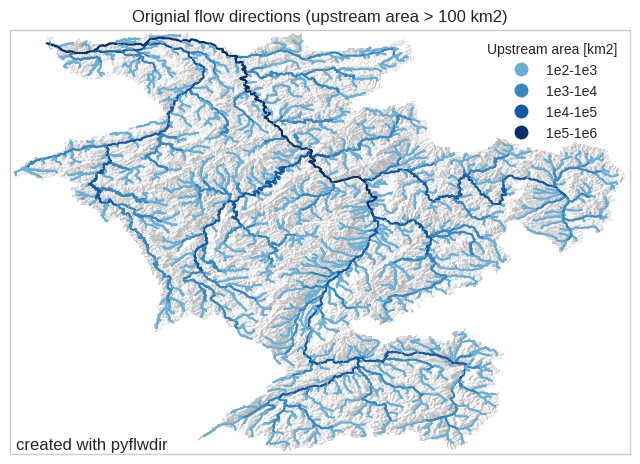

In [2]:
# vectorize streams for visualization,
uparea = flw.upstream_area()
feats0 = flw.streams(uparea > 100, uparea=uparea)
# base color and labels on log10 of upstream area
gdf_stream0 = gpd.GeoDataFrame.from_features(feats0, crs=crs)
gdf_stream0["logupa"] = np.floor(np.log10(gdf_stream0["uparea"])).astype(int)
labels = {2: "1e2-1e3", 3: "1e3-1e4", 4: "1e4-1e5", 5: "1e5-1e6"}
gdf_stream0["loglabs"] = [labels[k] for k in gdf_stream0["logupa"]]
# kew-word arguments for GeoDataFrame.plot method
gdf_plt_kwds = dict(
    column="loglabs",
    cmap=colors.ListedColormap(cm.Blues(np.linspace(0.5, 1, 7))),
    categorical=True,
    legend=True,
    legend_kwds=dict(title="Upstream area [km2]"),
)
title = f"Orignial flow directions (upstream area > 100 km2)"
ax = quickplot(
    gdfs=[(gdf_stream0, gdf_plt_kwds)], title=title, filename=f"flw_original"
)

## Flow direction upscaling

Methods to upcale flow directions are required as models often have a coarser resolution than the elevation data used to build them. Instead of deriving flow directions from upscaled elevation data, it is better to directly upscaling the flow direction data itself. The [upscale()](reference.rst#pyflwdir.FlwdirRaster.upscale) method implements the recently developed Iterative Hydrography Upscaling (**IHU**) algorithm ([Eilander et al 2020](https://doi.org/10.5194/hess-2020-582)). The method takes high resolution flow directions and upstream area grid to iterativly determine the best stream segment to represent in each upscaled cell. This stream segment is than traced towards the next downstream upscaled cell to determine the upscaled flow directions. Full details can be found in the referenced paper.

In [3]:
# upscale using scale_factor s
s = 10
flw1, idxs_out = flw.upscale(scale_factor=s, uparea=uparea, method="ihu")

Several methods are implemented based on the most downstream high-res pixel of each upscaled cell, the so-called outlet pixels. The location of these pixels can be used to derive the contributing area to each cell using the [ucat_area()](reference.rst#pyflwdir.FlwdirRaster.ucat_area) method. 

In [4]:
# get the contibuting unit area to each upscaled cell & accumulate
subareas = flw.ucat_area(idxs_out=idxs_out, unit="km2")[1]
uparea1 = flw1.accuflux(subareas)

In [5]:
# assess the quality of the upscaling
flwerr = flw.upscale_error(flw1, idxs_out)
percentage_error = np.sum(flwerr == 0) / np.sum(flwerr != 255) * 100
print(f"upscaling error in {percentage_error:.2f}% of cells")

upscaling error in 1.32% of cells


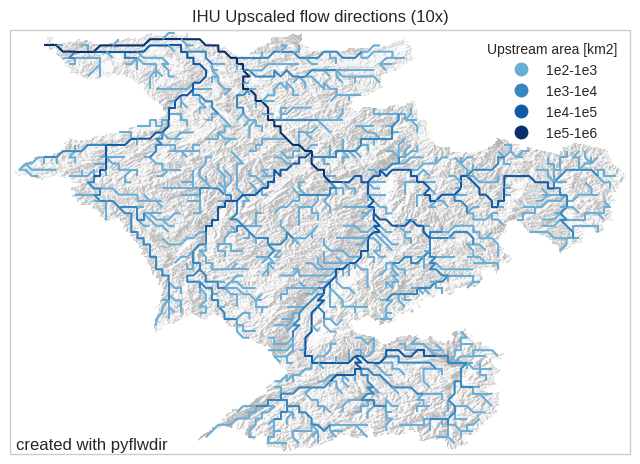

In [6]:
# vectorize streams for visualization
feats1 = flw1.streams(uparea1 > 100, uparea=uparea1)
# base color and labels on log10 of upstream area
gdf_stream1 = gpd.GeoDataFrame.from_features(feats1, crs=crs)
gdf_stream1["logupa"] = np.floor(np.log10(gdf_stream1["uparea"])).astype(int)
gdf_stream1["loglabs"] = [labels[k] for k in gdf_stream1["logupa"]]
# plot
title = f"IHU Upscaled flow directions ({s}x)"
ax = quickplot(
    gdfs=[(gdf_stream1, gdf_plt_kwds)], title=title, filename=f"flw_upscale{s:2d}"
)